In [1]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
print("Libraries imported.")

# --- Load the Processed Data ---
DIABETES_PROCESSED_DIR = os.path.join("..", "data", "processed", "diabetes")

X_train = joblib.load(os.path.join(DIABETES_PROCESSED_DIR, "X_train.joblib"))
X_test = joblib.load(os.path.join(DIABETES_PROCESSED_DIR, "X_test.joblib"))
y_train = joblib.load(os.path.join(DIABETES_PROCESSED_DIR, "y_train.joblib"))
y_test = joblib.load(os.path.join(DIABETES_PROCESSED_DIR, "y_test.joblib"))

print("\nDiabetes data loaded successfully!")

Libraries imported.

Diabetes data loaded successfully!


In [3]:
# Calculate the ratio of negative class to positive class
# scale_pos_weight = count(negative class) / count(positive class)
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

print(f"Scale Position Weight for XGBoost: {scale_pos_weight:.2f}")

Scale Position Weight for XGBoost: 1.87


In [4]:
# --- Logistic Regression ---
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("--- Logistic Regression Results ---")
print(classification_report(y_test, y_pred_log_reg))

# --- Random Forest ---
# We can tell RandomForest to handle imbalance with class_weight='balanced'
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print("\n--- Random Forest Results ---")
print(classification_report(y_test, y_pred_rf))

# --- XGBoost ---
# Here we use the scale_pos_weight parameter
xgb_clf = XGBClassifier(eval_metric='logloss', random_state=42, scale_pos_weight=scale_pos_weight)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
print("\n--- XGBoost Results ---")
print(classification_report(y_test, y_pred_xgb))

--- Logistic Regression Results ---
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       100
           1       0.60      0.50      0.55        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.67       154
weighted avg       0.70      0.71      0.70       154


--- Random Forest Results ---
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       100
           1       0.65      0.57      0.61        54

    accuracy                           0.74       154
   macro avg       0.71      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154


--- XGBoost Results ---
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       100
           1       0.64      0.63      0.64        54

    accuracy                           0.75       154
   macro avg       0.72      0.72   

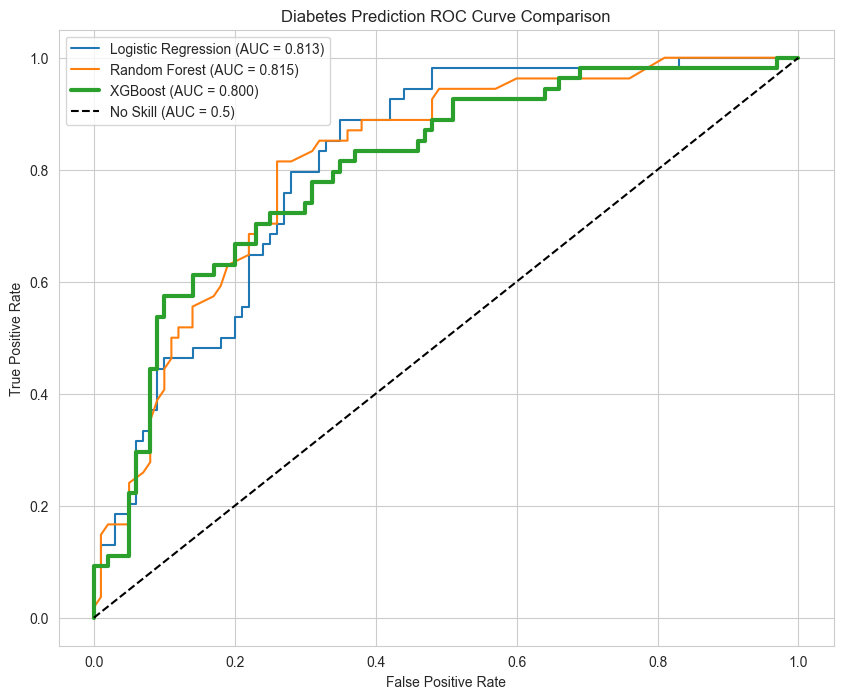

Logistic Regression AUC: 0.813
Random Forest AUC: 0.815
XGBoost AUC: 0.800


In [5]:
# Get prediction probabilities for each model
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1]
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Calculate ROC curve data
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

# Calculate AUC scores
auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
auc_rf = roc_auc_score(y_test, y_prob_rf)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

# Plot the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {auc_log_reg:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})', linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Diabetes Prediction ROC Curve Comparison')
plt.legend()
plt.show()

print(f"Logistic Regression AUC: {auc_log_reg:.3f}")
print(f"Random Forest AUC: {auc_rf:.3f}")
print(f"XGBoost AUC: {auc_xgb:.3f}")

In [6]:
# *** IMPORTANT: Change this line based on your results! ***
# Let's assume XGBoost is our best model.
best_model = xgb_clf 

# Define the path to save the model
DIABETES_MODELS_DIR = os.path.join("..", "models", "diabetes")
MODEL_PATH = os.path.join(DIABETES_MODELS_DIR, "best_diabetes_classifier.joblib")

# Save the model
joblib.dump(best_model, MODEL_PATH)

print(f"\nBest diabetes model ({type(best_model).__name__}) saved successfully to: {MODEL_PATH}")


Best diabetes model (XGBClassifier) saved successfully to: ..\models\diabetes\best_diabetes_classifier.joblib
